In [2]:
#Importing necessary libraries

import tensorflow as tf
import os, keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import imgaug.augmenters as iaa
import numpy as np
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
# Define the path to the data directory

data_dir = '/Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Files (Code & Dataset)/Sign_Lang_Custom_Dataset _Final copy'
test_dir = '/Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Files (Code & Dataset)/Sign_Lang_Custom_Dataset _Final copy'
IMAGE_SIZE=128
BATCH_SIZE=32

# Calculate the split sizes
train_split = 0.7
val_split = 0.2
test_split = 0.1

# Get the total number of images
total_images = sum([len(files) for r, d, files in os.walk(data_dir)])

# Calculate the number of images for each split
train_size = int(total_images * train_split)
val_size = int(total_images * val_split)
test_size = int(total_images * test_split)

# Calculate the steps per epoch for training and validation
train_steps_per_epoch = train_size // BATCH_SIZE
val_steps_per_epoch = val_size // BATCH_SIZE
test_steps_per_epoch = test_size // BATCH_SIZE

In [4]:
# Data generator for training set for Custom Model
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    validation_split=0.3
)

# Data generator for validation set
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=val_split
)

# Data generator for testing set (no data augmentation)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                               rotation_range=10,
                                                               width_shift_range=0.1,
                                                                height_shift_range=0.1,
                                                               horizontal_flip=True,
                                                                shear_range=0.1,
                                                                  zoom_range=0.1,
                                                               brightness_range=[0.7, 1.3],
    channel_shift_range=5,  # Color Jittering
    preprocessing_function=lambda x: x + np.random.normal(0, 0.1, x.shape),
)


In [5]:
# Load the data for training set
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

#Load the data for validation set
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load the data for testing set
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE,
class_mode='categorical',
shuffle=False,
)

Found 87958 images belonging to 36 classes.
Found 37669 images belonging to 36 classes.
Found 125627 images belonging to 36 classes.


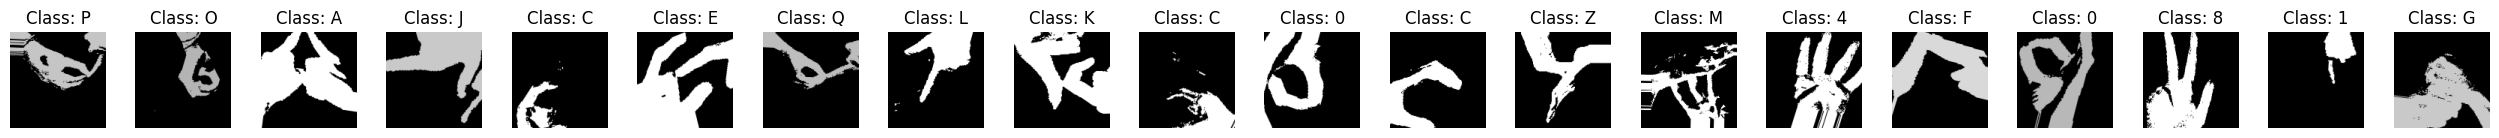

In [6]:
# Extracting class labels from the training generator
labels = [k for k in train_generator.class_indices]

# Generating a batch of samples from the training generator
sample_generate = train_generator.next()

# Extracting images and titles (labels) from the generated batch
images = sample_generate[0]
titles = sample_generate[1]

# Creating a Matplotlib figure
plt.figure(figsize=(32, 32))

# Looping through the images and titles to create subplots
for i in range(20):
    # Creating a subplot
    plt.subplot(20, 20, i + 1)

    # Adjusting subplot spacing
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # Displaying the image
    plt.imshow(images[i])

    # Displaying the class label as the title
    plt.title(f'Class: {labels[np.argmax(titles[i], axis=0)]}')

    # Turning off axis for better visualization
    plt.axis("off")

# Showing the plot
plt.show()

In [7]:
# Creating a Sequential model
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, strides=2))
model.add(Dropout(0.25))

# Second Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, strides=2))
model.add(Dropout(0.25))

# Third Convolutional Layer
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, strides=2))
model.add(Dropout(0.25))

# Fourth Convolutional Layer
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, strides=2))
model.add(Dropout(0.25))

In [8]:
# Flatten the output from the convolutional layers
model.add(Flatten())

# Dense layer with 512 units and ReLU activation, using L2 regularization
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Dense layer with 256 units and ReLU activation, using L2 regularization
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer with 36 units and softmax activation (assuming it's a 36-class classification problem)
model.add(Dense(36, activation='softmax'))

In [9]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 128)       5

In [11]:
# Specify the path to save the entire model
model_save_path = '/Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Files (Code & Dataset)/MyModel/Model_Custom_1_F.h5'

# Create a ModelCheckpoint callback to save the model during training
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False
)

# Create an EarlyStopping callback to stop training early if the validation loss doesn't improve
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)


In [12]:
# Function to print a message every 5 minutes
import time
def print_keep_alive():
    while True:
        print("VS Code session is active.")
        time.sleep(400)  # Wait for 5 minutes

# Start the keep-alive loop in the background
import threading
keep_alive_thread = threading.Thread(target=print_keep_alive)
keep_alive_thread.daemon = True
keep_alive_thread.start()

VS Code session is active.


In [13]:
# Training the custom model using the fit method
history=model.fit(train_generator,
                  steps_per_epoch=len(train_generator),
                  epochs=20,
                  validation_data=validation_generator,
                  validation_steps=len(validation_generator),
                  callbacks=[cp_callback, es_callback]
                 )


Epoch 1/20
2749/2749 [==============================] - ETA: 0s - loss: 4.1272 - accuracy: 0.3942VS Code session is active.

Epoch 1: saving model to /Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Files (Code & Dataset)/MyModel/Model_Custom_1_F.h5
2749/2749 [==============================] - 5517s 2s/step - loss: 4.1272 - accuracy: 0.3942 - val_loss: 3.3188 - val_accuracy: 0.6826
Epoch 2/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2749/2749 [==============================] - ETA: 0s - loss: 3.6410 - accuracy: 0.6443VS Code session is active.

Epoch 2: saving model to /Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Files (Code & Dataset)/MyModel/Model_Custom_1_F.h5
2749/2749 [==============================] - 5278s 2s/step - loss: 3.6410 - accuracy: 0.6443 - val_loss: 3.2677 - val_accuracy: 0.7823
Epoch 3/20
2749/2749 [==============================] - ETA: 0s - loss: 3.3307 - accuracy: 0.7224
Epoch 3: saving model to /Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Files (Code & Dataset)/MyModel/Model_Custom_1_F.h5
2749/2749 [==============================] - 16830s 6s/step - loss: 3.3307 - accuracy: 0.7224 - val_loss: 3.2848 - val_accuracy: 0.7205
Epoch 4/20
2749/2749 [==============================] - ETA: 0s - loss: 3.0914 - accuracy: 0.7619VS Code session is active.

Epoch 4: saving model to /Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Fi

# An example image with the augmentations applied

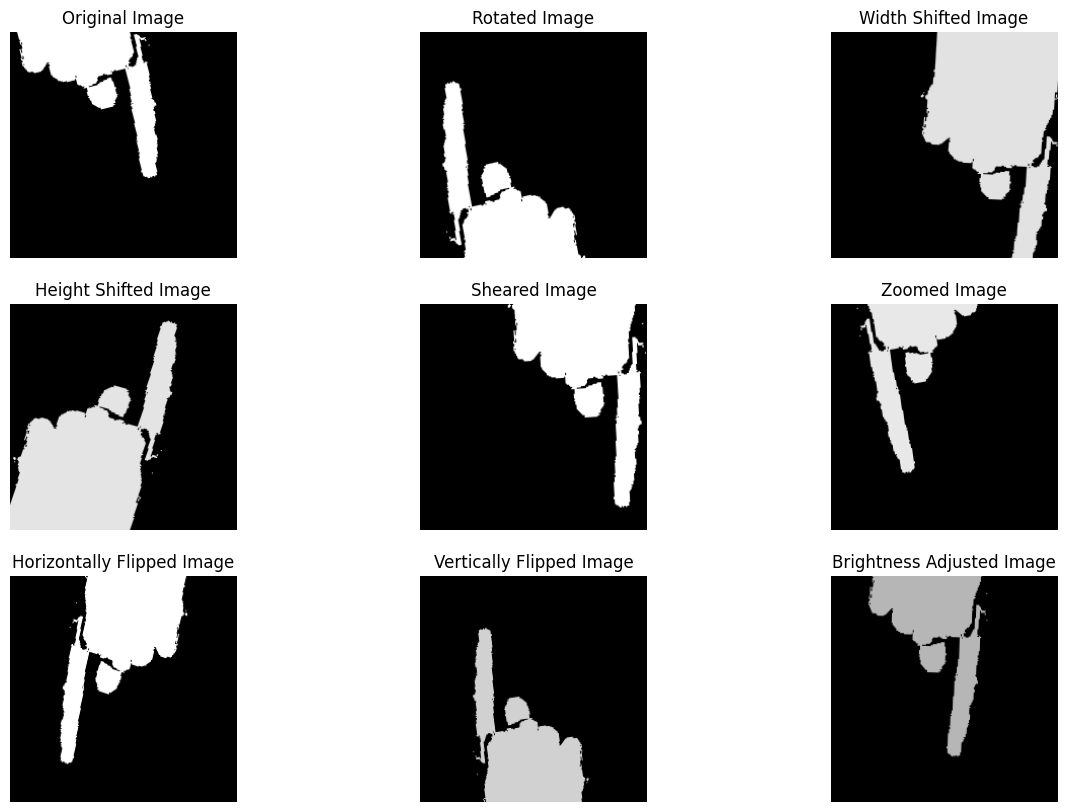

In [ ]:
#Import necessary libraries
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Image path
img_path = '/content/drive/MyDrive/DS/Test_NEW_SK_A_Z_1_9/1/010.png'

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  # Reshape to (1, height, width, channels)

# Data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3]
)

# Generate augmented images
augmented_images = []

# Apply each augmentation and store the augmented images
for i in range(9):  # Generate 9 augmented images
    augmented_img = next(datagen.flow(img_array, batch_size=1))[0]
    augmented_images.append(augmented_img)

# Titles for each augmented image
titles = [
    "Original Image",
    "Rotated Image",
    "Width Shifted Image",
    "Height Shifted Image",
    "Sheared Image",
    "Zoomed Image",
    "Horizontally Flipped Image",
    "Vertically Flipped Image",
    "Brightness Adjusted Image"
]

# Display the images
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(titles[i])
    plt.axis('off')

plt.show()

# Custom Model Feature Visualization

1/1 [==============================] - 0s 104ms/step


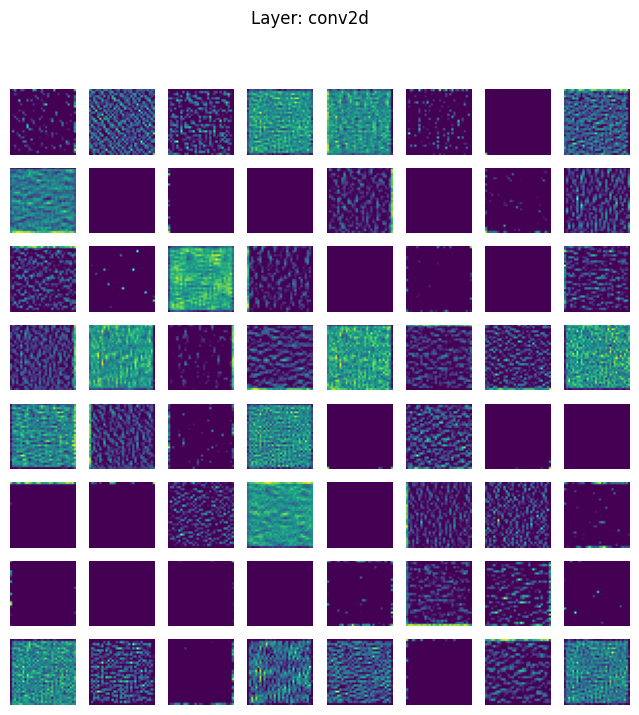

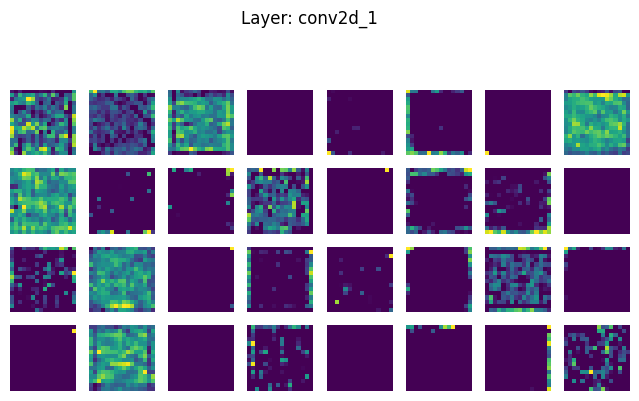

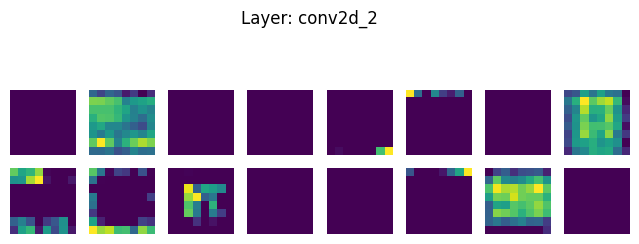

In [ ]:
#Import necessary libraries
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.models import load_model


# Assuming your model is named 'model_1'
model_1 = load_model('/Users/sujaykaushik/Documents/Msc DataScience/Project Dissertation/All Files (Code & Dataset)/MyModel/Model_Custom.h5')
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2']  # Names of the convolutional layers you want to visualize
num_layers = len(layer_names)

# Create a new model that outputs the intermediate layer activations
activation_models = [Model(inputs=model_1.inputs, outputs=model_1.get_layer(layer_name).output) for layer_name in layer_names]

# Load an example image (replace this with your own image data)
example_image = np.random.random((1, 32, 32, 3))

# Get the intermediate layer activations for the example image
activations = [activation_model.predict(example_image) for activation_model in activation_models]

# Plot the feature maps
for i in range(num_layers):
    plt.figure(figsize=(8, 8))
    for j in range(activations[i].shape[-1]):
        plt.subplot(8, 8, j + 1)
        plt.imshow(activations[i][0, :, :, j], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Layer: {layer_names[i]}')
    plt.show()
